In [1]:
%load_ext tensorboard
!pip install catboost shap -q
!mkdir logs && mkdir logs/fit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 30.3 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/helias/shap.git@support-adaboost

  Cloning https://github.com/helias/shap.git (to revision support-adaboost) to /tmp/pip-req-build-eixxndjw
  Running command git clone --filter=blob:none --quiet https://github.com/helias/shap.git /tmp/pip-req-build-eixxndjw
  Running command git checkout -b support-adaboost --track origin/support-adaboost
  Switched to a new branch 'support-adaboost'
  Branch 'support-adaboost' set up to track remote branch 'support-adaboost' from 'origin'.
  Resolved https://github.com/helias/shap.git to commit 06ebfdd29b28191a1faac992c9b5c246b2d70a54
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for shap: filename=shap-0.43.0-cp310-cp310-linux_x86_64.whl size=529734 sha256=21c0f0bee089420dcd7a38df2acf1b2f58d85036f9efa75d384ec001f5fdd46f
  Stored in directory: /tmp/pip-ephem-wheel-cache-5pgwwdpv/wheels/64/28/31/ffa7aadbf277c8059b1eeff0a2dfdd854c9221b500f8

In [2]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt
import random

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn import set_config
set_config(transform_output="pandas")
from sklearn.metrics import r2_score, mean_squared_log_error

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [4]:
#Import the links and import the data
# links=pd.read_csv("links.csv")
# links.values[0][0]
df=pd.read_csv("data.csv")
df.drop("\n\n\n\nCar type\n",axis=1,inplace=True)
df.drop("\n\n\n\nMake\n",axis=1,inplace=True)
df.drop("\n\n\n\nModel\n",axis=1,inplace=True)
df.drop("\n\n\n\nYear\n",axis=1,inplace=True)
df.drop("\n\n\n\nEngine Capacity\n",axis=1,inplace=True)
df.drop("\n\n\n\nTransmission\n",axis=1,inplace=True)
df.drop("\n\n\n\nSeat Capacity\n",axis=1,inplace=True)
df.drop("\n\n\n\nMileage\n",axis=1,inplace=True)
df.drop("\n\n\n\nColour\n",axis=1,inplace=True)

print(df.iloc[:,60:].isnull().sum()/df.shape[0])
print((df.isnull().sum()/df.shape[0]).sum()/df.shape[1])

Front Brakes                    0.139238
Rear Brakes                     0.167447
Exterior                        0.800735
Cupholders                      0.657487
Instrument cluster              0.855882
Power windows                   0.482420
Split fold read seat            0.654211
Steering tilt                   0.731751
CD                              0.641243
USB                             0.842981
Alarm                           0.327473
ISOFIX                          0.496858
Seat belts                      0.431751
Rim material                    0.332152
series                          0.063102
Front Thread                    0.379211
Rear Thread                     0.379211
Side Airbags                    0.817714
Final Drive Ratio               0.765174
Fuel Consumption (L/100km)      0.919184
Remote locking                  0.572259
Aux                             0.863503
Boot operation                  0.916243
Immobilizer                     0.849866
Interior lightin

In [5]:
df.loc[df.model=="Corolla Altis"].series.value_counts()[:10]

G           679
E           312
V           128
E Sporty     10
G Sporty      1
Name: series, dtype: int64

In [6]:
#Replace wrong series values for Hiace
df.loc[(df.series=="Window") | (df.series=="Panel"),"series"]="-"

assembled=df[df.Assembled.isnull()]
#These instances have very incomplete information thus dropping
#print(df[df.Assembled.isnull()].head())
df.drop(df[df.Assembled.isnull()].index,axis=0,inplace=True)
assembled

,Transmission,Number of Gears,Doors,Seat Capacity,Assembled,Engine CC,Peak Power (hp),Peak Torque (Nm),Engine Model,Engine Type,...,Sunroof,Radio,Sunshades,CO2 Emission,iPod,Heads-up display,Interior dashboard,Interior seat,Electric steering adjustment,Auto start/stop
31,Automatic,NaN,5.0,8.0,NaN,2362.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,Automatic,NaN,5.0,7.0,NaN,2362.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,Automatic,NaN,5.0,5.0,NaN,1986.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,Automatic,NaN,5.0,8.0,NaN,2382.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,Automatic,NaN,4.0,5.0,NaN,1986.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14818,Automatic,NaN,4.0,5.0,NaN,1794.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14823,Manual,NaN,5.0,7.0,NaN,1298.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14837,Manual,NaN,5.0,7.0,NaN,1298.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14895,Automatic,NaN,5.0,8.0,NaN,2362.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df['series'].fillna("-",inplace=True)

df['Auto start/stop'].isnull().sum()/df.shape[0] #Totally null
df.drop("Auto start/stop",axis=1,inplace=True)

#df["0-100mk/h (seconds)"] unknown column
df.drop("0-100mk/h (seconds)",axis=1,inplace=True)

df["Top Speed (km/h)"].value_counts()
df.drop("Top Speed (km/h)",axis=1,inplace=True)
df.drop("Radio",axis=1,inplace=True) # (87.99% missing)
df.drop("Interior seat",axis=1,inplace=True) #97.55% missing
df.drop("Seat belts",axis=1,inplace=True) # (95.93% missing)
df.drop("Other",axis=1,inplace=True) # (95.93% missing)
df.drop("Boot Space (litres)",axis=1,inplace=True)# 95.62% missing
df.drop("Parking brake",axis=1,inplace=True)#Parking brake drop (96.14% missing)
df.drop("Brake lights",axis=1,inplace=True)#Brake lights (85.87% missing)
df.drop("Fuel Consumption (L/100km)",axis=1,inplace=True)#Fuel consumption (94.13% missing)
df.drop("Final Drive Ratio",axis=1,inplace=True)#Final drive ratio (73.04% missing)
df.drop("Air-conditioning",axis=1,inplace=True)

#Combining into one single name
# df['name']=df['model']+" "+df['series']
# shortlisted=df['name'].value_counts().index[df['name'].value_counts()>100]
# df=df[df['name'].isin(shortlisted)].reset_index(drop=True)
#df['name']=df['model']+" "+df['series']+" "+df["manufactured_year"].apply(str)
# df.drop("model",axis=1,inplace=True)
# df.drop("series",axis=1,inplace=True)
# df.drop("brand",axis=1,inplace=True)
# df['name']

#Too many values
df.drop(["Engine Model"],axis=1,inplace=True)

#Too many types, and the size of the tyre is represented inside Front Rim, Rear RIm
df.drop("Front Tyre",axis=1,inplace=True)
df.drop("Rear Tyre",axis=1,inplace=True)
df.drop(["Engine Type","Steering Type","brand","condition"],axis=1,inplace=True) #Same values


In [8]:
for col in ["Cruise control","Hill start assist","Side Airbags","Aux","Steering telescopic","Seatbelt reminder","Power steering","Sunroof", "Steering wheel controls", \
            "CO2 Emission","iPod","Heads-up display","Interior dashboard","Lane-keeping assist","Child safety lock","Reverse camera", \
            "Leather seats", "Power driver seat", "Auto wipers", "Engine start", "Parking sensor","Power side mirror", \
            "Sunshades", "Bluetooth", "Multi function screen","Front foglamps","Headlamps","LED Daytime running lights","Rear foglamps", \
            "Side mirror turning indicators","ABS/EBD","Blind spot info (BLIS)","Stability control","Cupholders","Instrument cluster", \
            "Steering tilt","Immobilizer","Boot operation","Remote locking","Interior lighting","Auto headlamps","Power door","Taillamps", \
            "Leather steering", "Power passenger seat","Split fold read seat","ISOFIX","Front Airbags","Curtain Airbags","Power windows","Exterior"]:
  df.loc[df[col].notnull(),col]=1
  df.loc[df[col].isnull(),col]=0
  df[col]=df[col].astype(int)
df.loc[df["Electric steering adjustment"].notnull(),"Steering telescopic"]=1
df.loc[df["Electric steering adjustment"].notnull(),"Power steering"]=1
#Electric steering adjustment only value: Power tilt and telescopic steering column
df.drop("Electric steering adjustment",axis=1,inplace=True)
#df.drop("Interior seat",axis=1,inplace=True) #97.55% missing

def get_num_speaker(speakers):
  # if speakers==float('nan'): return None
  speakers=speakers.split(" ")
  for i,s in enumerate(speakers):
    if "speaker" in s.lower():
      return speakers[i-1]
    return 0
col="Speaker"
df["Speaker"]=df["Speaker"].str.replace("8 - Speaker", "8 Speakers")
df["Speaker"].fillna("0 Speakers",inplace=True)
df["Speaker"]=df["Speaker"].apply(get_num_speaker)
df["Speaker"]=df["Speaker"].astype(int)
#
# Brake lights (85.66%)
#Side airbags combine with Blind spot info (BLIS) and Front Airbags

df["USB"].fillna("No USB",inplace=True)
df["USB_Bluetooth"]=df["USB"].str.contains("Bluetooth").astype(int)
df["Bluetooth"]=df[["Bluetooth","USB_Bluetooth"]].max(axis=1)
df["USB_Aux"]=df["USB"].str.contains("Aux").astype(int)
df["Aux"]=df[["Aux","USB_Aux"]].max(axis=1)
df.drop(["USB_Aux","USB_Bluetooth"],axis=1,inplace=True)
df.loc[df["USB"]=="No USB","USB"]=0
df.loc[df["USB"]!=0,"USB"]=1
df["USB"]=df["USB"].astype(int)

df["Alarm"].fillna("No Alarm",inplace=True)
df.loc[df["Alarm"].str.contains("Immobilizer"),"Immobilizer"]=1
df.loc[df["Alarm"]=="No Alarm","Alarm"]=0
df.loc[df["Alarm"]!=0,"Alarm"]=1
df["Alarm"]=df["Alarm"].astype(int)

df["Navigation"].fillna("No Navigation",inplace=True)
df.loc[df["Navigation"].str.contains("Reverse Camera"),"Reverse camera"]=1
df.loc[df["Navigation"].str.contains("Bluetooth"),"Bluetooth"]=1
df.loc[df["Navigation"].str.contains("monitor"),"Multi function screen"]=1
df.loc[df["Navigation"]=="No Navigation","Navigation"]=0
df.loc[df["Navigation"]!=0,"Navigation"]=1
df["Navigation"]=df["Navigation"].astype(int)

df["CD"].fillna("No CD",inplace=True)
df.loc[df["CD"].str.contains("AUX"),"Aux"]=1
df.loc[df["CD"].str.contains("USB"),"USB"]=1
df.loc[df["CD"].str.contains("iPod"),"iPod"]=1
df.loc[df["CD"].str.contains("monitor"),"Multi function screen"]=1
#df.loc[df["CD"].str.contains("AM/FM"),"Radio"]=True
df["CD_Speaker"]=df["CD"].apply(get_num_speaker)
df["CD_Speaker"].fillna("0",inplace=True)
df["Speaker"]=df[["CD_Speaker","Speaker"]].max(axis=1)
df.loc[df["CD"]=="No CD","CD"]=0
df.loc[df["CD"]!=0,"CD"]=1
df["CD"]=df["CD"].astype(int)
df.drop(["CD_Speaker"],axis=1,inplace=True)
# Audio - 1-CD player                                             951
# AM/FM Tuner, CD-Player, MP3, AUX Input                          671
# 2 -DIN-1-CD,MP3 / 6 Speakers                                    435
# 1-DIN-1-CD/ 4 Speakers                                          340
# 2-DIN-1-CD,MP3 / 4 Speakers                                     277
# Audio  - Tuner, CD Player, MP3, USB & iPod                      265
# Audio - CD / DVD Player                                         237
# Audio - DVD Player                                              222
# 2-Din Tuner CD/MP3 Player                                       218
# AM/FM Tuner, CD-Player, MP3, AUX Input, Radio with CD player    172
# Audio - DVD Player, CD tuner (MP3/WMA)                          165
# Audio - CD changer                                               71
# Audio - CD changer - boot                                        60
# 2-Din Tuner CD/MP3 Player, Audio - DVD Player                    39
# 1-DIN-1-CD/ 4 Speakers, Audio - 1-CD player                      19
# 2 -DIN-CD Changer,MP3 / 6 Speakers                                5

#get mileage as number
def clean_mileage(mileage):
  mileage=mileage.replace("km","").replace("K","000").replace("k","").strip()
  mileage=mileage.split(" - ")[-1]
  return mileage

def get_rim(rims):
  if not isinstance(rims,str): return rims
  # if speakers==float('nan'): return None
  rims=rims.split(" ")
  for i,s in enumerate(rims):
    if "alloy" in s.lower():
      return 1 #"Alloy"
  return 0 #"Steel"

df["mileage"]=df["mileage"].apply(clean_mileage)
df["mileage"]=df["mileage"].astype(int)

#Change price to numbers only
df["price"]=df["price"].str.replace("RM","").str.replace(",","").astype(int)
#Round off engine CC to nearest hundreds
df["Engine CC"]=df["Engine CC"]/100
df["Engine CC"]=df["Engine CC"].apply(math.ceil)*100


In [9]:
#Get inches as int only
df["Front Rim (inches)"]=df["Front Rim (inches)"].apply(lambda x:int(x[:2]) if isinstance(x,str) else x)
df["Rear Rim (inches)"]=df["Rear Rim (inches)"].apply(lambda x:int(x[:2]) if isinstance(x,str) else x)
#Standardize value
#df["Side Airbags"]=df["Side Airbags"].str.replace("Side airbags for driver and front passenger","Yes").str.replace("Side airbags integrated in front seats","Yes")


#Pink and Magenta only have 1 sample
# df.loc[df["colour"]=="Magenta","colour"]="Red"
# df.loc[df["colour"]=="Pink","colour"]="Red"

df.loc[df["Transmission"]=="Automatic","Transmission"]=True
df.loc[df["Transmission"]=="Manual","Transmission"]=False
df["Transmission"]=df["Transmission"].astype(int)

df["Rim material"]=df["Rim material"].apply(get_rim)

In [10]:
#Split to train, val and test
complete=df.copy()
for col in complete.columns:
  complete=complete[complete[col].notnull()]
test_index=complete.index

random.seed(42)
sampled=random.sample(list(test_index),int(df.shape[0]*0.1))
test=df[df.index.isin(sampled)].reset_index(drop=True)
train=df[~df.index.isin(sampled)].reset_index(drop=True)

#random.seed(42)
#sampled=random.sample(list(train.index),int(train.shape[0]/9))
#val=train[train.index.isin(sampled)].reset_index(drop=True)
#train=train[~train.index.isin(sampled)].reset_index(drop=True)

In [11]:
y_train=train["price"]
X_train=train.drop(["price"],axis=1)
#y_val=val["price"]
#X_val=val.drop(["price"],axis=1)
y_test=test["price"]
X_test=test.drop(["price"],axis=1)

In [12]:
#Replacing major spec with the model closest to them (Can be improvised)
def SpecImputer(df):
  df['name']=df['model']+" "+df['series']
  for spec in ["Number of Gears","Front Suspension","Rear Suspension", "Bore (mm)","Stroke (mm)","Steering Radius","Kerb Weight (kg)", \
              "Front Rim (inches)","Rear Rim (inches)","Fuel Tank (litres)","Front Brakes","Rear Brakes","Rim material","Front Thread","Rear Thread", \
              "Peak Power (hp)","Peak Torque (Nm)","Direct Injection","Length (mm)","Width (mm)","Height (mm)","Wheel Base (mm)","Compression Ratio"]:
    print(spec, df[spec].isnull().sum()/df.shape[0])
    missing=df[df[spec].isnull()].name.value_counts().index.tolist()
    for model in missing:
      df.loc[(df[spec].isnull()) & (df.name==model),spec]=df[df.name==model][spec].mode()[0] if len(df[df.name==model][spec].mode())==1 else None
    missing=df[df[spec].isnull()].model.value_counts().index.tolist()
    for model in missing:
      #if df[spec].dtype=="object":
      df.loc[(df[spec].isnull()) & (df.model==model),spec]=df[df.model==model][spec].mode()[0] if len(df[df.name==model][spec].mode())==1 else df[spec].mode()[0]
      #else:
        #df.loc[(df[spec].isnull()) & (df.model==model),spec]=df[df.model==model][spec].mode()[0] if len(df[df.name==model][spec].mode())==1 else df[spec].mean()
  df.drop(["name"],axis=1,inplace=True)
  df["Front Rim (inches)"]=df["Front Rim (inches)"].astype(int)
  df["Rear Rim (inches)"]=df["Rear Rim (inches)"].astype(int)
  df["Rim material"]=df["Rim material"].astype(int)
  return df
X_train=SpecImputer(X_train)
#X_val=SpecImputer(X_val)

Number of Gears 0.10578951480584421
Front Suspension 0.19478084225330103
Rear Suspension 0.198531135244941
Bore (mm) 0.4287053676068443
Stroke (mm) 0.4287053676068443
Steering Radius 0.3240096882568951
Kerb Weight (kg) 0.07281818892100946
Front Rim (inches) 0.22423626845847333
Rear Rim (inches) 0.22423626845847333
Fuel Tank (litres) 0.11641534494882412
Front Brakes 0.10500820376591921
Rear Brakes 0.13797952965075397
Rim material 0.3304945698882725
Front Thread 0.3854988670989921
Rear Thread 0.3854988670989921
Peak Power (hp) 0.00039065551996249706
Peak Torque (Nm) 0.00039065551996249706
Direct Injection 0.00023439331197749826
Length (mm) 0.0023439331197749823
Width (mm) 0.0023439331197749823
Height (mm) 0.0023439331197749823
Wheel Base (mm) 0.00039065551996249706
Compression Ratio 0.5157434174544886


In [13]:
#Multicollinearity, refer VIF below
vif_gt10=["Front Rim (inches)","Front Thread","Rear Thread","Wheel Base (mm)","manufactured_year","Length (mm)","Height (mm)",
                      "Stroke (mm)","Rear Rim (inches)","Bore (mm)","Engine CC","Doors","Kerb Weight (kg)","Compression Ratio",
                      "Rim material","Peak Power (hp)","Number of Gears","Width (mm)","Steering Radius","ABS/EBD",
                      "Fuel Tank (litres)","Transmission","Seat Capacity","Alarm","Front Airbags","Rear foglamps","ISOFIX",
                      "Power side mirror","Power passenger seat"]
# X_train.drop(vif_gt10,axis=1,inplace=True)
# X_val.drop(vif_gt10,axis=1,inplace=True)
# X_test.drop(vif_gt10,axis=1,inplace=True)
#df.drop(["Front Rim (inches)","Front Thread","Kerb Weight (kg)","Peak Torque (Nm)","Height (mm)","Wheel Base (mm)","Engine CC","Bore (mm)","Rear foglamps"],axis=1,inplace=True)
X_train

,Transmission,Number of Gears,Doors,Seat Capacity,Assembled,Engine CC,Peak Power (hp),Peak Torque (Nm),Direct Injection,Aspiration,...,Child safety lock,Seatbelt reminder,Lane-keeping assist,Power steering,Sunroof,Sunshades,CO2 Emission,iPod,Heads-up display,Interior dashboard
0,1,7.0,5.0,5.0,Official Import,1800,140.0,171.0,Multi-Point Injected,Aspirated,...,0,0,0,0,0,0,0,0,0,0
1,1,7.0,4.0,5.0,Locally Built,1500,107.0,140.0,Multi-Point Injected,Aspirated,...,0,0,0,0,0,0,0,0,0,0
2,1,7.0,5.0,7.0,Parallel Import,2400,170.0,224.0,Multi-Point Injected,Aspirated,...,0,0,0,0,0,0,0,0,0,0
3,1,4.0,5.0,5.0,Parallel Import,2400,160.0,221.0,Multi-Point Injected,Aspirated,...,0,0,0,0,0,0,0,0,0,0
4,1,4.0,4.0,5.0,Locally Built,1500,109.0,141.0,Multi-Point Injected,Aspirated,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12794,1,4.0,5.0,7.0,Locally Built,1500,109.0,141.0,Multi-Point Injected,Aspirated,...,0,0,0,0,0,0,0,0,0,0
12795,1,4.0,5.0,7.0,Locally Built,1500,109.0,141.0,Multi-Point Injected,Aspirated,...,0,0,0,0,0,0,0,0,0,0
12796,1,4.0,5.0,7.0,Official Import,1500,103.0,136.0,Multi-Point Injected,Aspirated,...,0,0,0,0,0,0,0,0,0,0
12797,1,7.0,5.0,7.0,Parallel Import,2400,170.0,220.0,Multi-Point Injected,Aspirated,...,0,0,0,0,0,0,0,0,0,0


In [14]:
pd.options.display.max_columns=150
X_train=X_train.reset_index(drop=True)
X_train

,Transmission,Number of Gears,Doors,Seat Capacity,Assembled,Engine CC,Peak Power (hp),Peak Torque (Nm),Direct Injection,Aspiration,Fuel Type,Length (mm),Width (mm),Height (mm),Wheel Base (mm),Fuel Tank (litres),Front Suspension,Rear Suspension,Front Rim (inches),Rear Rim (inches),Leather seats,Power driver seat,Auto wipers,Engine start,Hill start assist,Parking sensor,Power side mirror,Reverse camera,Bluetooth,Multi function screen,Speaker,Front foglamps,Headlamps,LED Daytime running lights,Rear foglamps,Side mirror turning indicators,ABS/EBD,Blind spot info (BLIS),Curtain Airbags,Front Airbags,Stability control,model,manufactured_year,mileage,colour,Bore (mm),Stroke (mm),Compression Ratio,Steering Radius,Kerb Weight (kg),Front Brakes,Rear Brakes,Exterior,Cupholders,Instrument cluster,Power windows,Split fold read seat,Steering tilt,CD,USB,Alarm,ISOFIX,Rim material,series,Front Thread,Rear Thread,Side Airbags,Remote locking,Aux,Boot operation,Immobilizer,Interior lighting,Auto headlamps,Cruise control,Navigation,Power door,Steering wheel controls,Taillamps,Leather steering,Steering telescopic,Power passenger seat,Child safety lock,Seatbelt reminder,Lane-keeping assist,Power steering,Sunroof,Sunshades,CO2 Emission,iPod,Heads-up display,Interior dashboard
0,1,7.0,5.0,5.0,Official Import,1800,140.0,171.0,Multi-Point Injected,Aspirated,Petrol - Unleaded (ULP),4360.0,1795.0,1565.0,2640.0,50.0,Macpherson Strut,do,17,17,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,C-HR,2018,45000,White,72.0,91.8,10.0,10.2,2010.0,Ventilated discs,Discs,0,0,0,0,0,0,0,0,0,0,1,-,1470.0,1460.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,7.0,4.0,5.0,Locally Built,1500,107.0,140.0,Multi-Point Injected,Aspirated,Petrol - Unleaded (ULP),4410.0,1700.0,1475.0,2550.0,42.0,Macpherson Strut,Torsion Beam,15,15,0,0,0,0,0,1,1,1,1,0,0,1,1,1,1,1,1,0,0,1,1,Vios,2017,105000,Black,72.0,91.8,10.0,10.2,1095.0,Ventilated discs,Drums,1,1,1,1,1,1,1,1,1,1,1,E,1470.0,1460.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,7.0,5.0,7.0,Parallel Import,2400,170.0,224.0,Multi-Point Injected,Aspirated,Petrol - Unleaded (ULP),4885.0,1840.0,1900.0,2950.0,42.0,Macpherson Strut,Torsion Beam,15,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,Alphard,2014,75000,Black,72.0,91.8,10.0,11.8,1890.0,Ventilated discs,Discs,0,0,0,0,0,0,0,0,0,1,1,G 240S Gold,1555.0,1560.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,4.0,5.0,5.0,Parallel Import,2400,160.0,221.0,Multi-Point Injected,Aspirated,Petrol - Unleaded (ULP),4730.0,1845.0,1680.0,2715.0,75.0,Macpherson Strut,Multiple links,15,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,Harrier,2004,110000,Black,88.5,96.0,9.6,5.7,1600.0,Ventilated discs,Discs,0,0,0,0,0,0,0,0,0,0,1,240G,1575.0,1575.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,4.0,4.0,5.0,Locally Built,1500,109.0,141.0,Multi-Point Injected,Aspirated,Petrol - Unleaded (ULP),4300.0,1700.0,1460.0,2550.0,42.0,Macpherson Strut,Torsion Beam,14,14,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,Vios,2012,145000,Silver,72.0,91.8,10.0,10.2,1050.0,Ventilated discs,Drums,0,0,0,0,1,1,1,0,1,0,1,E,1470.0,1460.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12794,1,4.0,5.0,7.0,Locally Built,1500,109.0,141.0,Multi-Point Injected,Aspirated,Petrol - Unleaded (ULP),4120.0,1635.0,1695.0,2655.0,45.0,Macpherson Strut,Coil Spring,15,15,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,Avanza,2011,95000,Blue,72.0,91.8,10.0,9.4,1100.0,Ventilated discs,Drums,0,0,0,0,1,0,1,0,1,0,1,G,1415.0,1425.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12795,1,4.0,5.0,7.0,Locally Built,1500,109.0,141.0,Multi-Point Injected,Aspirated,Petrol - Unleade

In [15]:
X_train.to_csv("train.csv",index=False)

In [28]:
X_train.loc[X_train.model=="Vios"].mode()[["manufactured_year","CD","Immobilizer","USB",
                                           "mileage","Engine CC","Width (mm)","Length (mm)",
                                           "Front Rim (inches)","Rear Rim (inches)",
                                           "Kerb Weight (kg)","Number of Gears","Peak Power (hp)",
                                           "Peak Torque (Nm)","Front Thread","Rear Thread",
                                           "Parking sensor","Side mirror turning indicators"]]

,manufactured_year,CD,Immobilizer,USB,mileage,Engine CC,Width (mm),Length (mm),Front Rim (inches),Rear Rim (inches),Kerb Weight (kg),Number of Gears,Peak Power (hp),Peak Torque (Nm),Front Thread,Rear Thread,Parking sensor,Side mirror turning indicators
0,2014,0,1,0,85000,1500,1700.0,4410.0,15,15,1090.0,4.0,109.0,141.0,1470.0,1460.0,1,1


In [23]:
y_train[X_train.loc[X_train.model=="Vios"].index]

1        56800
4        31400
5        50800
7        56800
10       31400
         ...  
12781    27800
12786    26868
12788    59980
12791    35000
12792    29500
Name: price, Length: 2652, dtype: int64

In [ ]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# def calc_vif(X):

#     # Calculating VIF
#     vif = pd.DataFrame()
#     for col in X.columns:
#       if X[col].dtype=="object":
#         X.drop(col,axis=1,inplace=True)
#     vif["variables"] = X.columns
#     vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

#     return(vif)

# #vif=calc_vif(X_train)
# #vif.loc[vif["VIF"]>=10].sort_values("VIF",ascending=False)[:50]
# vif_gt10=["Front Rim (inches)","Front Thread","Rear Thread","Wheel Base (mm)","manufactured_year","Length (mm)","Height (mm)",
#                       "Stroke (mm)","Rear Rim (inches)","Bore (mm)","Engine CC","Doors","Kerb Weight (kg)","Compression Ratio",
#                       "Rim material","Peak Power (hp)","Number of Gears","Width (mm)","Steering Radius","ABS/EBD",
#                       "Fuel Tank (litres)","Transmission","Seat Capacity","Alarm","Front Airbags","Rear foglamps","ISOFIX",
#                       "Power side mirror","Power passenger seat"]
# dropped=X_train.drop(vif_gt10,axis=1)
# vif=calc_vif(dropped)
# vif.loc[vif["VIF"]>=10].sort_values("VIF",ascending=False)

# Modelling

In [ ]:
# ###Please add your own models here
# estimator = CatBoostRegressor(depth=10,
#                           iterations=30000,
#                           learning_rate=0.001,
#                           subsample=0.5,
#                           colsample_bylevel=1,
#                           min_data_in_leaf=5,
#                           eval_metric = 'R2',
#                           random_seed = 42,
#                           train_dir="logs/fit",
#                           verbose=True,
#                           use_best_model=True)

# estimator = RandomForestRegressor(n_estimators=200,
#                                   max_depth=30,
#                                   min_samples_split=5,
#                                   min_samples_leaf=1,
#                                   max_features='sqrt',
#                                   random_state=42)

base_estimator = DecisionTreeRegressor(max_depth=10,
                                       min_samples_split=10,
                                       min_samples_leaf=1)
estimator = AdaBoostRegressor(base_estimator=base_estimator, n_estimators=200, learning_rate = 0.001, random_state=42)

In [ ]:
num_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()

num_categorical_transformer = Pipeline(steps=[
    ('num', StandardScaler())
])

ordinal_categorical_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
])

# Preprocessing for categorical data
one_hot_categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore',drop="first"))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('scaling',num_categorical_transformer, num_cols),
        ('oe',ordinal_categorical_transformer, ["model","colour","series"]),
        ('ohe', one_hot_categorical_transformer, ['Assembled','Direct Injection','Aspiration','Fuel Type', \
                                                  'Front Suspension','Rear Suspension','Front Brakes','Rear Brakes'])
    ])
scaler=StandardScaler()
pipeline = Pipeline([
    ('preprocessor',preprocessor)])
pipeline.fit(X_train,y_train)
#X_train_trans=pipeline.transform(X_train)
#X_val_trans=pipeline.transform(X_val)
X_test_trans=pipeline.transform(X_test)
pipeline.steps.append(('estimator', estimator))

In [ ]:
y_train=y_train.reset_index(drop=True)
y_train

0        108000
1         56800
2        153366
3         36066
4         31400
          ...  
12794     26000
12795     20800
12796     37999
12797     45800
12798      9800
Name: price, Length: 12799, dtype: int64

In [ ]:
#Cross validation to get the best parameters
# parameters = {'estimator__depth' : [10],
#               'estimator__learning_rate' : [0.001],
#               'estimator__iterations'    : [6000],
#               'estimator__subsample'    : [0.5],
#               'estimator__colsample_bylevel'    : [1],
#               'estimator__min_data_in_leaf'    : [5],
#               'estimator__use_best_model': [False]
#               }

# parameters = {'estimator__n_estimators' : [200, 300],
#               'estimator__max_depth' : [30, 40],
#               'estimator__min_samples_split' : [5, 10],
#               'estimator__min_samples_leaf' : [1]
#               }

parameters = {'estimator__n_estimators': [200],
              'estimator__learning_rate': [0.001]
              }


cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
model = GridSearchCV(pipeline, param_grid = parameters, cv = cv)
model.fit(X_train, y_train)
model.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", l

{'estimator__learning_rate': 0.001, 'estimator__n_estimators': 200}

In [ ]:
# pipeline.fit(X_train, y_train, estimator__eval_set=(X_val_trans,y_val))
# y_pred = pipeline.predict(X_test)

In [ ]:
y_pred = model.predict(X_test)
print("Catboost - R2: ", r2_score(y_test, y_pred))
print("Catboost - RMSLE: ", mean_squared_log_error(y_test, y_pred,squared=False))
# Catboost - R2:  0.9105007141983239
# Catboost - RMSLE:  0.11871524525590184

Catboost - R2:  0.9105007141983239
Catboost - RMSLE:  0.11871524525590184


In [ ]:
model.best_estimator_[-1].save_model("catboost")

In [ ]:
# Random Forest
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Random Forest - R2: ", r2_score(y_test, y_pred))
print("Random Forest - RMSLE: ", mean_squared_log_error(y_test, y_pred,squared=False))
# Random Forest - R2:  0.926614580946876
# Random Forest - RMSLE:  0.10419451395361956

Random Forest - R2:  0.926614580946876
Random Forest - RMSLE:  0.10419451395361956


In [ ]:
# Decision Tree Regression with AdaBoost
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Decision Tree Regression with AdaBoost - R2: ", r2_score(y_test, y_pred))
print("Decision Tree Regression with AdaBoost - RMSLE: ", mean_squared_log_error(y_test, y_pred,squared=False))
# Decision Tree Regression with AdaBoost - R2:  0.9430102522268722
# Decision Tree Regression with AdaBoost - RMSLE:  0.11168440068093732

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Decision Tree Regression with AdaBoost - R2:  0.9430102522268722
Decision Tree Regression with AdaBoost - RMSLE:  0.11168440068093732


In [ ]:
import joblib
joblib.dump(model.best_estimator_, 'model.pkl', compress = 1)
joblib.dump(model, 'pipeline.pkl', compress = 1)

['pipeline.pkl']

  0%|          | 0/1422 [00:00<?, ?it/s]

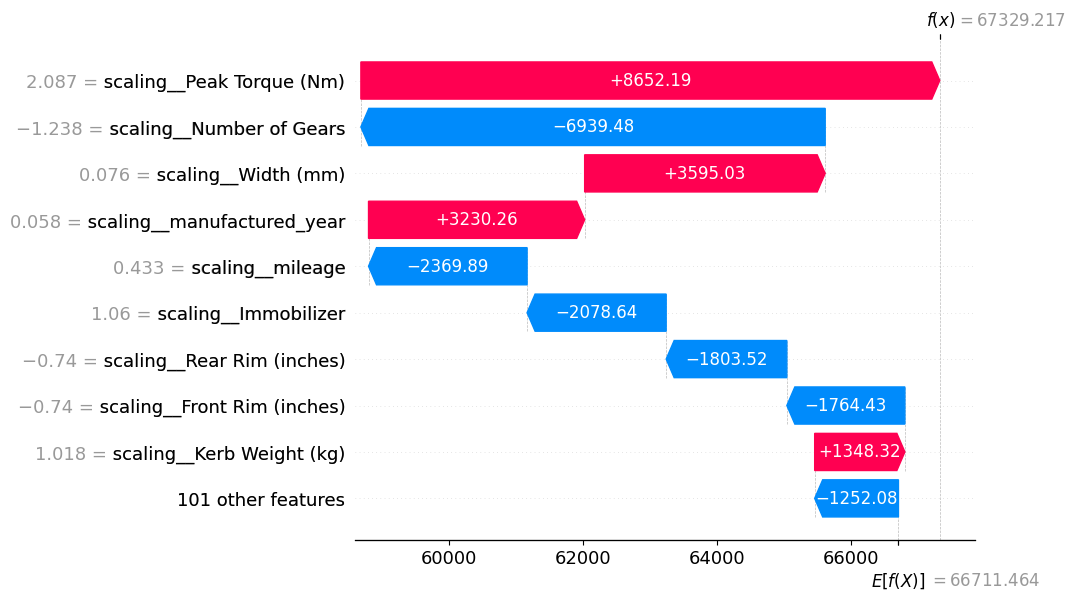

In [ ]:
import shap
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
#explainer = shap.Explainer(model.best_estimator_[-1])
explainer=shap.KernelExplainer(model.best_estimator_[-1].predict,X_test_trans[:5])
shap_values = explainer(X_test_trans)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

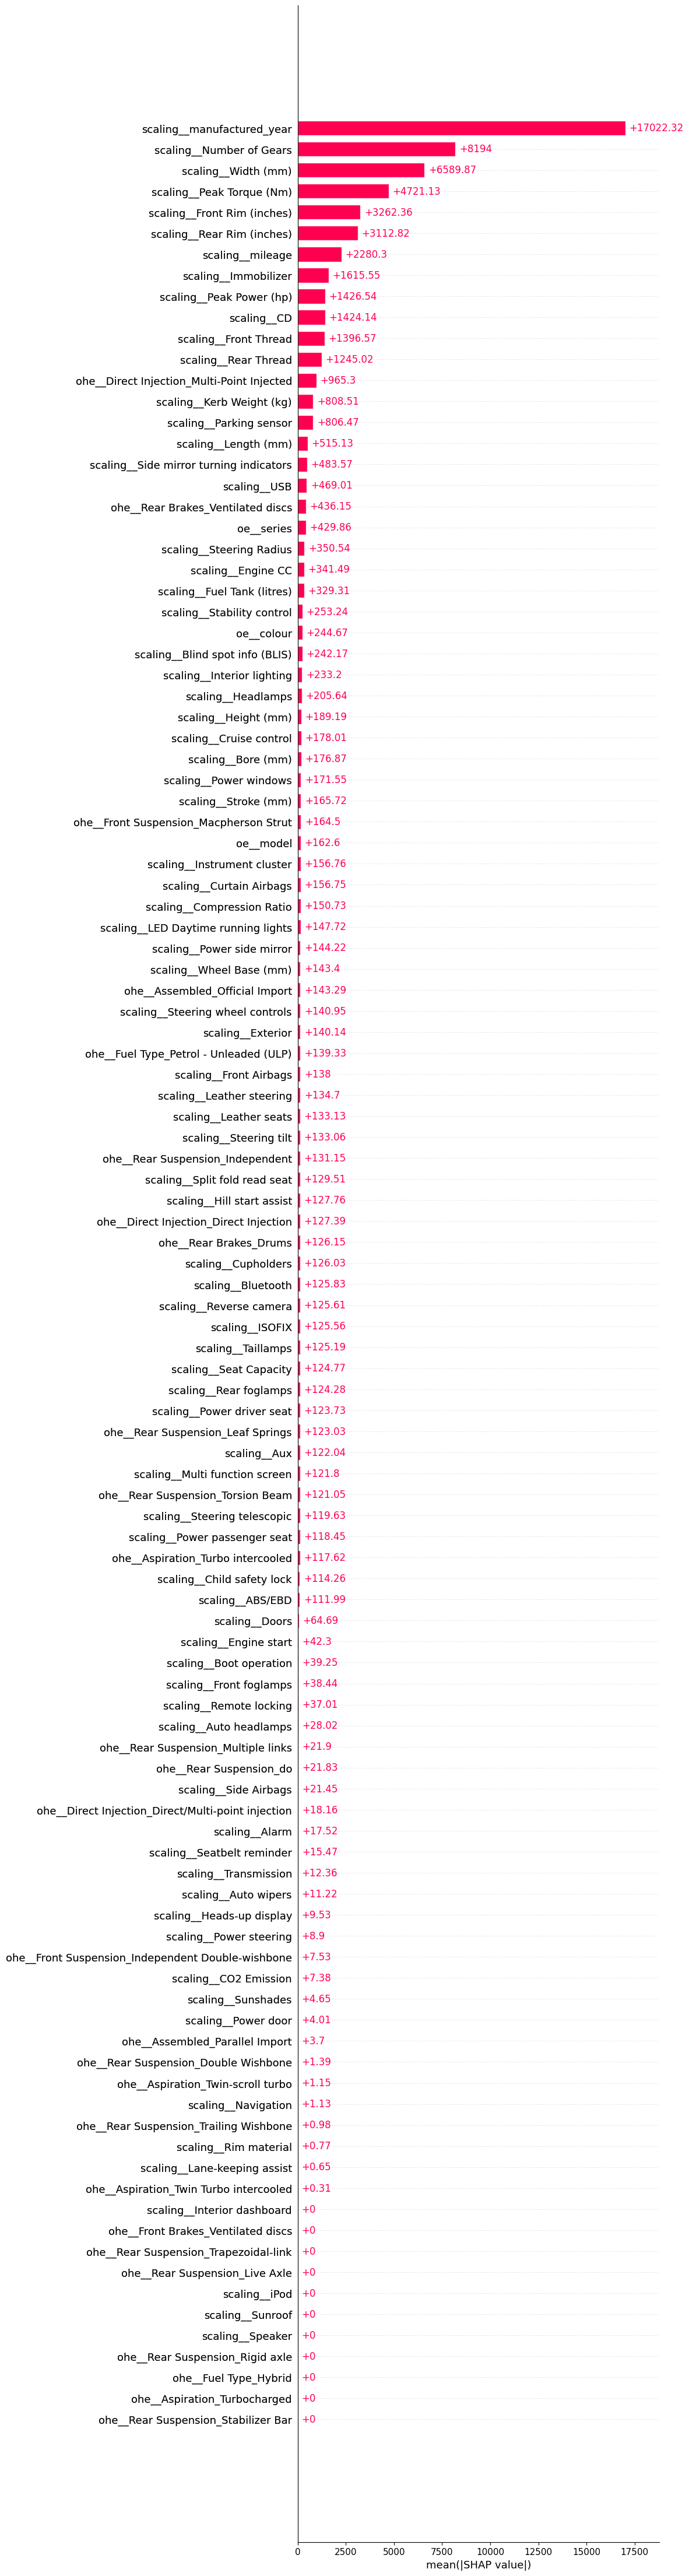

In [ ]:
shap.plots.bar(shap_values, max_display=110)

In [ ]:
shap.plots.force(shap_values[0],matplotlib=True)

In [ ]:
for i in range(10):
  print(y_test[i], y_pred[i])

71800 67329.21739130435
142000 141288.88888888888
68800 68553.44696969698
42800 40160.15
18800 16225.615023474178
47800 64886.742268041235
78800 76477.0172413793
14800 16077.93175074184
13800 20424.565217391304
154800 132379.25


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_trans,y_train)
f_i = list(zip(X_train_trans.columns,rf.feature_importances_))
f_i.sort(key = lambda x : -x[1])
f_i[:50]

In [ ]:
# scaler=StandardScaler()
# scaler.fit(y_train.values.reshape(-1,1))
# y_train=scaler.transform(y_train.values.reshape(-1,1))
# y_test=scaler.transform(y_test.values.reshape(-1,1))
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
xgr = XGBRegressor()
xgr.fit(X_train_trans, y_train)
y_pred = xgr.predict(X_test_trans)
print("XGBoost - R2: ",
      r2_score(y_test, y_pred))

XGBoost - R2:  0.7682828384766212


# No pipeline (ignore)

In [ ]:
# for col in ["model","colour","series"]:
#   encoder=OrdinalEncoder().fit(X_train[[col]])
#   X_train[col]=encoder.transform(X_train[[col]])

# for col in X_train.columns:
#   if X_train[col].dtype=="object":
#     encoder=OneHotEncoder(drop="first").fit(X_train[[col]])
#     df2=pd.DataFrame(encoder.transform(X_train[[col]]).toarray(),columns=encoder.get_feature_names_out())
#     df2[encoder.get_feature_names_out()]=df2[encoder.get_feature_names_out()].astype(int)
#     X_train=pd.concat([X_train,df2],axis=1)
#     X_train.drop(col,axis=1,inplace=True)

# for col in X_train.select_dtypes(include='number').columns:
#   scaler=StandardScaler()
#   X_train[col]=scaler.fit_transform(X_train[[col]])

# X_test=X_test.reset_index(drop=True)
# y_test=y_test.reset_index(drop=True)
# for col in ["model","colour","series"]:
#   encoder=OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
#   encoder.fit(X_ori[[col]])
#   X_test[col]=encoder.transform(X_test[[col]])
# for col in X_ori.columns:
#   if X_test[col].dtype=="object":
#     encoder=OneHotEncoder(handle_unknown='ignore',drop="first").fit(X_ori[[col]])
#     df2=pd.DataFrame(encoder.transform(X_test[[col]]).toarray(),columns=encoder.get_feature_names_out())
#     df2[encoder.get_feature_names_out()]=df2[encoder.get_feature_names_out()].astype(bool)
#     X_test=pd.concat([X_test,df2],axis=1)
#     X_test.drop(col,axis=1,inplace=True)
# for col in X_ori.select_dtypes(include='number').columns:
#   scaler=StandardScaler()
#   scaler.fit(X_ori[[col]])
#   X_test[col]=scaler.transform(X_test[[col]])

# Generate csv (no need run)

In [ ]:
# #Import libraries
# from urllib.request import Request, urlopen
# from bs4 import BeautifulSoup
# hdr = {'User-Agent': 'Mozilla/5.0'}

In [ ]:
# #Extract links for Toyota until page 300 (15000 samples)
# links=[]
# for i in range(1,301):
#   URL = "https://www.carlist.my/used-cars-for-sale/toyota/malaysia?page_size=50&page_number={}".format(str(i))

#   req = Request(URL,headers=hdr)
#   page = urlopen(req)
#   soup = BeautifulSoup(page)
#   results = soup.find_all("a",{"class":"listing__overlay one-whole inline--block valign--top relative"})
#   for r in results:
#     links.append(r['href'])
# #Save the links as a csv file for reuse in event of Colab crashing
# csv=pd.DataFrame({'links':links})
# csv.to_csv("links.csv",index=False)

In [ ]:
# #Extract information from websites
# for i,link in enumerate(links.values[12000:]):
#   if i%100==0:
#     #Save dataset
#     df.to_csv("data.csv",index=False)
#   try:
#     print(link)
#     URL = link[0]
#     req = Request(URL,headers=hdr)
#     page = urlopen(req)
#     soup = BeautifulSoup(page)
#     results = soup.find_all("span",{"class":"u-width-1/2"})
#     #results = soup.find_all("span",{"class":"u-text-bold u-width-1/2 u-align-right"})
#     car={}
#     for i in range(0,len(results),2):
#       car[results[i].text]=results[i+1].text
#     results = soup.find_all("span",{"itemprop":"name"})
#     car["brand"]=results[2].text
#     car["model"]=results[3].text
#     series=""
#     if len(results)>4:
#       car["series"]=results[4].text
#     results = soup.find_all("span",{"class":"u-text-bold u-block"})
#     car["condition"]=results[0].text
#     car["manufactured_year"]=results[1].text
#     car["mileage"]=results[2].text
#     car["colour"]=results[3].text
#     results=soup.find_all("h3",{"class":"u-color-white u-text-3 u-text-4@mobile u-text-bold u-margin-bottom-none u-margin-top-xxs"})
#     #Special sale exception
#     try:
#       car["price"]=results[0].text
#     except:
#       continue
#     # engine_cap=results[4].text
#     # transmission=results[5].text
#     # seat_cap=results[6].text
#     #df2=pd.DataFrame(car,index=[0])
#     df=pd.concat([df,pd.DataFrame.from_records([car])])
#   except:
#     print("Car sold")
# df=df.reset_index(drop=True)
# df

In [ ]:
# df.to_csv("data.csv",index=False)